# Titanic Project

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic collided with an iceberg, sinking into one of the most infamous shipwrecks in history. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers & crew. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this project, I used machine learning to create five base models, to predict whether a person on the Titanic was likely to survive or die. These models are:

1. Logistic Regression
2. Support Vector Machine
3. Multilayer Perceptron
4. Random Forest
5. Gradient Boosting

Following which, I created a stacked Ensemble Learning Model, making use of the predicted results of the five models above in an attempt to improve the overall performance. This model was created using XGBoost.

In [1]:
# data analysis & wrangling
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# machine learning
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# miscellaneous
from time import time
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [2]:
# import all 3 datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
results = pd.read_csv("results.csv")

# combine the datasets
full_test = test.merge(results, on = "PassengerId", how = "left")
data = pd.concat([train, full_test], sort = False)
data = data.reset_index(drop = True)
data.index = np.arange(1, len(data) + 1)
display(data)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1305,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1308,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Data Cleaning

In [3]:
display(data.isnull().sum())
# counts of Age, Cabin, Embarked, Fare missing

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [4]:
# replace missing Age with mean
data["Age"].fillna(data["Age"].mean(), inplace = True)

In [5]:
# replace missing Fare with Mean
data["Fare"].fillna(data["Fare"].mean(), inplace = True)

In [6]:
# assume that passengers with a cabin entry owns a room on the ship, the rest without
# create a column to reflect if a passenger has a room or not {yes: 1, no: 0}
data["Cabin"] = np.where(data["Cabin"].isnull(), 0, 1)

In [7]:
# replace missing Embarked with mode
data.groupby(["Embarked"]).sum() # trainset mode is 'S'
data["Embarked"].fillna("S", inplace = True)

## Feature Engineering

In [8]:
# create column FamilySize based on SibSp & Parch
data["FamilySize"] = data["SibSp"] + data["Parch"]

In [9]:
# map the Sex column {female: 0, male: 1}
data["Sex"] = data["Sex"].map({"female": 0, "male": 1})

In [10]:
# map the Embarked column {S: 0, C: 1, Q: 2}
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

In [11]:
# change variable datatypes from integer to categorical
data[["Survived", "Sex", "Cabin"]] = data[["Survived", "Sex", "Cabin"]].astype(object)

## Feature Selection

In [12]:
# drop redundant columns
data.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket"], axis = 1, inplace = True)

In [13]:
train = data[:891]
test = data[891:]

# train data
X_train = train.drop("Survived", axis = 1)
Y_train = train["Survived"].astype(int)

# test data
X_test = test.drop("Survived", axis = 1)
Y_test = test["Survived"].astype(int)

## Correlation Visualisation

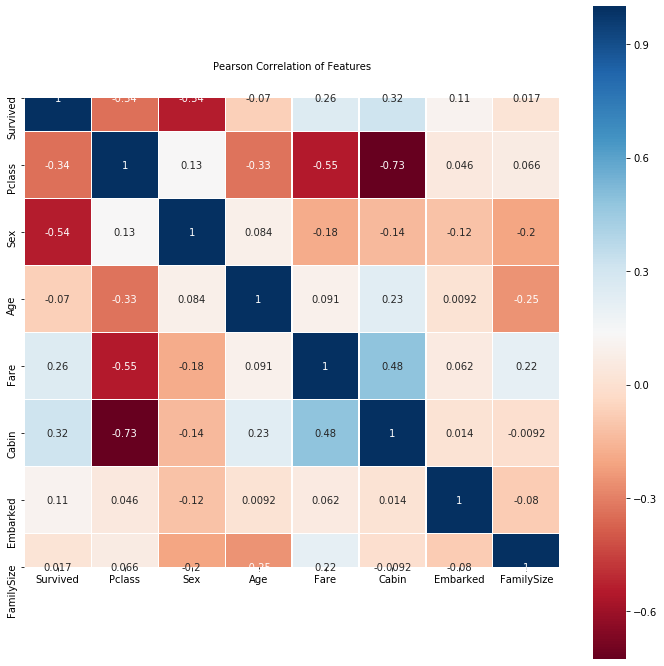

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize = (12, 12))
plt.title("Pearson Correlation of Features", y = 1.05, size = 10)
display(sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = "white", annot = True))

## Base Models
### Logistic Regression Model

In [15]:
def print_results(results):
    print("The Best Parameters: {}\n".format(results.best_params_))

    means = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(mean, 3), round(std * 2, 3), params))
        
lr = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

cv = GridSearchCV(lr, parameters, cv = 5)
cv.fit(X_train, Y_train.values.ravel())

print_results(cv)

The Best Parameters: {'C': 1}

0.686 (+/-0.081) for {'C': 0.001}
0.709 (+/-0.075) for {'C': 0.01}
0.797 (+/-0.035) for {'C': 0.1}
0.801 (+/-0.03) for {'C': 1}
0.8 (+/-0.022) for {'C': 10}
0.799 (+/-0.025) for {'C': 100}
0.799 (+/-0.025) for {'C': 1000}


In [16]:
# the best logistic regression model
logisticregression = cv.best_estimator_

### Support Vector Machine Model

In [17]:
def print_results(results):
    print("The Best Parameters: {}\n".format(results.best_params_))

    means = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(mean, 3), round(std * 2, 3), params))
        
svc = SVC()
parameters = {
    "kernel": ["linear", "rbf"],
    "C": [0.1, 1, 10]}

cv = GridSearchCV(svc, parameters, cv = 5)
cv.fit(X_train, Y_train.values.ravel())

print_results(cv)

The Best Parameters: {'C': 0.1, 'kernel': 'linear'}

0.788 (+/-0.04) for {'C': 0.1, 'kernel': 'linear'}
0.616 (+/-0.003) for {'C': 0.1, 'kernel': 'rbf'}
0.788 (+/-0.04) for {'C': 1, 'kernel': 'linear'}
0.676 (+/-0.1) for {'C': 1, 'kernel': 'rbf'}
0.788 (+/-0.04) for {'C': 10, 'kernel': 'linear'}
0.705 (+/-0.057) for {'C': 10, 'kernel': 'rbf'}


In [18]:
# the best svm model
svm = cv.best_estimator_

### Multilayer Perceptron

In [19]:
def print_results(results):
    print("The Best Parameters: {}\n".format(results.best_params_))

    means = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(mean, 3), round(std * 2, 3), params))
        
mlp = MLPClassifier()
parameters = {
    "hidden_layer_sizes": [(10,), (50,), (100,)],
    "activation": ["relu", "tanh", "logistic"],
    "learning_rate": ["constant", "invscaling", "adaptive"]}

cv = GridSearchCV(mlp, parameters, cv = 5)
cv.fit(X_train, Y_train.values.ravel())

print_results(cv)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimize

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimize

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimize

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimize

The Best Parameters: {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}

0.754 (+/-0.095) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.74 (+/-0.076) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.764 (+/-0.046) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.787 (+/-0.046) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.786 (+/-0.035) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.79 (+/-0.048) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.797 (+/-0.044) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.788 (+/-0.02) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.788 (+/-0.047) for {'activation': 'relu', 'hidden_layer_sizes': (100,)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [20]:
# the best mlperceptron model
mlperceptron = cv.best_estimator_

### Random Forest

In [21]:
def print_results(results):
    print("The Best Parameters: {}\n".format(results.best_params_))

    means = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(mean, 3), round(std * 2, 3), params))
        
rf = RandomForestClassifier()
parameters = {
    "n_estimators": [5, 50, 250],
    "max_depth": [2, 4, 8, 16, 32, None]}

cv = GridSearchCV(rf, parameters, cv = 5)
cv.fit(X_train, Y_train.values.ravel())

print_results(cv)

The Best Parameters: {'max_depth': 8, 'n_estimators': 50}

0.772 (+/-0.047) for {'max_depth': 2, 'n_estimators': 5}
0.782 (+/-0.069) for {'max_depth': 2, 'n_estimators': 50}
0.796 (+/-0.064) for {'max_depth': 2, 'n_estimators': 250}
0.787 (+/-0.065) for {'max_depth': 4, 'n_estimators': 5}
0.816 (+/-0.064) for {'max_depth': 4, 'n_estimators': 50}
0.809 (+/-0.071) for {'max_depth': 4, 'n_estimators': 250}
0.811 (+/-0.046) for {'max_depth': 8, 'n_estimators': 5}
0.831 (+/-0.054) for {'max_depth': 8, 'n_estimators': 50}
0.822 (+/-0.059) for {'max_depth': 8, 'n_estimators': 250}
0.801 (+/-0.052) for {'max_depth': 16, 'n_estimators': 5}
0.822 (+/-0.059) for {'max_depth': 16, 'n_estimators': 50}
0.811 (+/-0.06) for {'max_depth': 16, 'n_estimators': 250}
0.817 (+/-0.08) for {'max_depth': 32, 'n_estimators': 5}
0.81 (+/-0.066) for {'max_depth': 32, 'n_estimators': 50}
0.802 (+/-0.061) for {'max_depth': 32, 'n_estimators': 250}
0.795 (+/-0.065) for {'max_depth': None, 'n_estimators': 5}
0.81 (+/

In [22]:
# the best randomforest model
randomforest = cv.best_estimator_

### Gradient Boosting

In [23]:
def print_results(results):
    print("The Best Parameters: {}\n".format(results.best_params_))

    means = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(mean, 3), round(std * 2, 3), params))
        
gb = GradientBoostingClassifier()
parameters = {
    "n_estimators": [5, 50, 250, 500],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 1, 10, 100]}

cv = GridSearchCV(gb, parameters, cv = 5)
cv.fit(X_train, Y_train.values.ravel())

print_results(cv)

The Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}

0.616 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.787 (+/-0.038) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.789 (+/-0.043) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.811 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.616 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.793 (+/-0.049) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.816 (+/-0.029) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.822 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.616 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.804 (+/-0.059) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.819 (+/-0.049) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.831 (+/-0.052) for {'le

In [24]:
# the best randomforest model
gradientboosting = cv.best_estimator_

## Testing the Models

In [25]:
# create models dictionary
models = {
    "LR": logisticregression,
    "SVM": svm,
    "MLP": mlperceptron,
    "RF": randomforest,
    "GB": gradientboosting}

# create function to evaluate model
def evaluate_model(name, model, features, labels):
    start = time()
    prediction = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, prediction), 3)
    precision = round(precision_score(labels, prediction), 3)
    recall = round(recall_score(labels, prediction), 3)
    print("{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms".format(name, accuracy, precision, recall, round((end - start) * 1000, 1)))

In [26]:
# checking the models' results
for name, model in models.items():
    evaluate_model(name, model, X_test, Y_test)

LR -- Accuracy: 0.935 / Precision: 0.903 / Recall: 0.921 / Latency: 2.0ms
SVM -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 3.6ms
MLP -- Accuracy: 0.933 / Precision: 0.878 / Recall: 0.947 / Latency: 2.0ms
RF -- Accuracy: 0.868 / Precision: 0.839 / Recall: 0.789 / Latency: 12.0ms
GB -- Accuracy: 0.878 / Precision: 0.858 / Recall: 0.796 / Latency: 3.8ms


## Feature Importance

In [27]:
# creating a feature dataframe containing feature names & importance scores for different models
cols = X_train.columns.values
rf_features = list(randomforest.feature_importances_)
gb_features = list(gradientboosting.feature_importances_)
feature_dataframe = pd.DataFrame({
    "features": cols,
    "Random Forest feature importances": rf_features,
    "Gradient Boosting feature importances": gb_features})

In [28]:
# plotting Random Forest feature importance
trace = go.Scatter(
    y = feature_dataframe["Random Forest feature importances"].values,
    x = feature_dataframe["features"].values,
    mode = "markers",
    marker = dict(sizemode = "diameter",
                  sizeref = 1,
                  size = 25,
                  color = feature_dataframe["Random Forest feature importances"].values,
                  showscale = True),
    text = feature_dataframe["features"].values)

layout = go.Layout(
    autosize = True,
    title = "Random Forest Feature Importance",
    hovermode = "closest",
    yaxis = dict(
        title = "Feature Importance",
        ticklen = 5,
        gridwidth = 2),
    showlegend = False)

fig = go.Figure(data = trace, layout = layout)
py.iplot(fig, filename = "scatter2010")

In [29]:
# plotting Random Forest feature importance
trace = go.Scatter(
    y = feature_dataframe["Gradient Boosting feature importances"].values,
    x = feature_dataframe["features"].values,
    mode = "markers",
    marker = dict(sizemode = "diameter",
                  sizeref = 1,
                  size = 25,
                  color = feature_dataframe["Gradient Boosting feature importances"].values,
                  showscale = True),
    text = feature_dataframe["features"].values)

layout = go.Layout(
    autosize = True,
    title = "Gradient Boosting Feature Importance",
    hovermode = "closest",
    yaxis = dict(
        title = "Feature Importance",
        ticklen = 5,
        gridwidth = 2),
    showlegend = False)

fig = go.Figure(data = trace, layout = layout)
py.iplot(fig, filename = "scatter2010")

In [32]:
feature_dataframe["mean"] = (feature_dataframe["Random Forest feature importances"] + feature_dataframe["Gradient Boosting feature importances"]) / 2

y = feature_dataframe["mean"].values
x = feature_dataframe["features"].values
data = [go.Bar(
    x = x,
    y = y,
    width = 0.5,
    marker = dict(
        color = feature_dataframe["mean"].values,
        colorscale = "Portland",
        showscale = True,
        reversescale = False),
    opacity = 0.8)]

layout = go.Layout(
    autosize = True,
    title = "Barplots of Mean Feature Importance",
    hovermode = "closest",
    yaxis = dict(
        title = "Feature Importance",
        ticklen = 5,
        gridwidth = 2),
    showlegend = False)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = "bar-direct-labels")

## Ensembling Model: Second-Level Predictions from First-Level Output

In [33]:
# using trainset predictions
base_predictions_train = pd.DataFrame({
    "LR": logisticregression.predict(X_train),
    "SVM": svm.predict(X_train),
    "MLP": mlperceptron.predict(X_train),
    "RF": randomforest.predict(X_train),
    "GB": gradientboosting.predict(X_train)})

# correlation heatmap of all models
data = [go.Heatmap(
        z = base_predictions_train.astype(int).corr().values,
        x = base_predictions_train.columns.values,
        y = base_predictions_train.columns.values,
        colorscale = "Viridis",
        showscale = True,
        reversescale = True)]
py.iplot(data, filename = "labelled-heatmap")

### XGBoost Model

In [35]:
def print_results(results):
    print("The Best Parameters: {}\n".format(results.best_params_))

    means = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(mean, 3), round(std * 2, 3), params))
        
xgbm = xgb.XGBClassifier()
parameters = {
    "learning_rate": [0.01, 0.1, 1, 10, 100],
    "n_estimators": [5, 50, 250],
    "max_depth": [2, 4, 8, 16, 32, None]}

cv = GridSearchCV(xgbm, parameters, cv = 5)
cv.fit(base_predictions_train, Y_train.values.ravel())

print_results(cv)

The Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}

0.936 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 5}
0.936 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
0.936 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 250}
0.934 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 5}
0.934 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
0.934 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 250}
0.934 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 5}
0.934 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 50}
0.934 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 250}
0.934 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 16, 'n_estimators': 5}
0.934 (+/-0.019) for {'learning_rate': 0.01, 'max_depth': 16, 'n_estimators': 50}
0.934 (+/-0.025) for {'lear

In [37]:
xgboost = cv.best_estimator_

In [38]:
# new test data to be used for prediction
base_predictions_test = pd.DataFrame({
    "LR": logisticregression.predict(X_test),
    "SVM": svm.predict(X_test),
    "MLP": mlperceptron.predict(X_test),
    "RF": randomforest.predict(X_test),
    "GB": gradientboosting.predict(X_test)})

In [39]:
# checking the model's results
evaluate_model("XGBoost", xgboost, base_predictions_test, Y_test)

XGBoost -- Accuracy: 0.864 / Precision: 0.819 / Recall: 0.803 / Latency: 3.1ms


# END